<a href="https://colab.research.google.com/github/nagamamo/financial_data_science/blob/main/5_1_montecarlo_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

5.　モンテカルロ法による株価の予測

　本例では、株価の予測例を、日経平均株価を例として紹介します。市場インデックスの予測は、マーケット・ポートフォリオの平均価格を予測することを意味します。マーケット・ポートフォリオの予測が、実務の現場で重視される理由は、シングル・ファクター・モデルやマルチ・ファクター・モデルでは、マーケット・ポートフォリオに市場インデックス株価を用いるケースが多いためです。このため、マーケット・ポートフォリオの予測値を算出することは、個別銘柄の見通しを考える際に役立ちます。

　本例では、まずデータ取得を目的とするpandas datareader、数値計算用にnumpy、math、確率分布に基づく乱数を発生させるためのrandom、そして図表用のライブラリであるmatplotlibを読み込みます。

In [1]:
#[1]ライブラリの読み込み
import pandas_datareader as data
import datetime
import numpy as np
from math import exp,sqrt
import random
import matplotlib.pyplot as plt

　次に上記のpandas_datareaderを用い、日経平均株価の日次データを取得します。ここでは日経平均株価のコード^NKXをAPIにより取得します。データフレーム名をnikkeiとして、標本期間を2021年1月1日から2022年11月30日とします。ドル円レートを予測する場合は、米セントルイス連銀（FRED）からドル円レートのコードDEXJPUSをtickers=[]内に記述して、入手元をFREDに書き換えてください。

In [2]:
#[2]データ取得
tickers=['^NKX'] #証券コードの指定
start=datetime.date(2000,1,1)#標本期間を2000年1月1日から
end=datetime.date(2024,4,30)#2024年4月30日までに指定
nikkei=data.DataReader('^NKX','stooq',start=start,end=end).sort_values(by='Date',ascending=True)

　次に日経平均株価の日次データの終値の対数差分からリターンを算出します。この株価リターンのデータフレーム名をd_nikkeiとします。続いて予測値を算出するため、この時系列データの直近の値である2022年11月30日の株価終値のみを切り取り、この終値の変数名をlastとします。この直近の値が、シミュレーションを行う際の出発点となります。

In [3]:
#[3]データ前処理
d_nikkei=np.log(nikkei.Close).diff(1)
last=nikkei.Close[-1]

　続いて株価変動モデルの実装に必要な変数定義と算出を行います。そして年間営業日数daysを250日と仮定し、平均値muと標準偏差sigmaをnumpyを用いて算出します。限界的な時間の経過Δtをdeltaと定義し、年間営業日数daysで除します。最後に平均mu、標準偏差sigmaの正規分布に従う乱数を発生させ、このデータフレーム名をｚとします。250営業日の試算を数千回から数万回実施するモンテカルロ法では、計算速度を踏まえ、主としてnumpy配列を用いることにします。

In [4]:
#[4]リターン・平均値・標準偏差の算出と変数の定義
days=250
mu=np.mean(d_nikkei)*days
sigma=np.std(d_nikkei)*np.sqrt(days)
delta_t=1/days
z=random.gauss(mu,sigma)

　次に離散化されたモデルを変数とともに定義します。モデル式の名称をbsmとして、Sは日経平均株価、sigmaは標準偏差、muは平均リターン、deltaは限界的な時間の経過、ｚは乱数です。

In [5]:
#[5]株価変動モデルの定義
def bsm(S,sigma,mu,delta_t,z):
  bsm= S*exp((mu-sigma**2/2)*delta_t+sigma*sqrt(delta_t)*z)
  return bsm

　続いて、2種類のシミュレーション実行回数を定義します。ひとつめの実行回数は予測期間である将来何日後までの株価を予測するかの定義です。本例ではこれを、1年後まで実行するため予測期間（p）を営業日数の250回とします。ふたつめの実行回数は、この250営業日のシミュレーションを何回反復するかの反復数（q）の定義です。本例では250営業日の反復を10,000回実行します。この1年月後の250営業日後までのデータ、10,000回の試算結果を格納するための、0を要素とする2種類のnumpy配列を生成します。初期値nikkei_F[0] には2024年4月30日の株価lastを与えます。

In [6]:
#[6]予測期間(p)・反復回数(q)・初期値他の定義と設定
p, q= 270, 10000
nikkei_F=np.zeros(p)
nikkei_F[0] = last
nikkei_F2=np.zeros(q)

　動作確認のため、[6]で定義した250回のシミュレーションを1度のみ実行します。この一回のみの試算では、一年後の株価は45,000近辺まで上昇する試算結果が得られます。当然のことながら、この試算結果はrandom.gauss(mu,sigma)がいかなる乱数を生成するかに依存しますので、同様の動作確認を再び実行すると異なる結果が得られます。

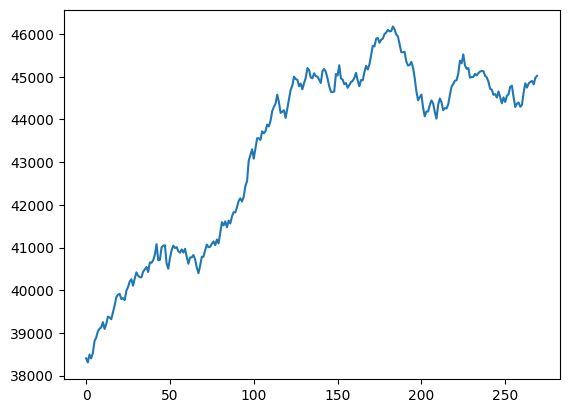

In [7]:
#[7]p営業日後までのシミュレーションの実行：単数回
for n in range(1,len(nikkei_F)):
    nikkei_F[n]=bsm(nikkei_F[n-1],sigma,mu,delta_t,random.gauss(mu,sigma))
plt.plot(nikkei_F)

　[7]のシミュレーションをｑ回反復するためのソースコードが下記の[8]です。

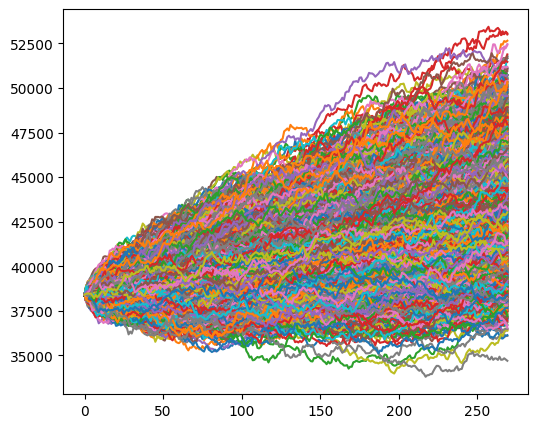

In [8]:
#[8]p営業日後までのシミュレーションをq回反復
plt.figure(figsize=(6,5))
for i in range(1,q):
  for n in range(1,len(nikkei_F)):
    nikkei_F[n]=bsm(nikkei_F[n-1],sigma,mu,delta_t,random.gauss(mu,sigma))
  plt.plot(nikkei_F)
  nikkei_F2[i]=nikkei_F[-1]
  nikkei_F3=np.delete(nikkei_F2,0)

　モンテカルロ法による日経平均株価のシミュレーションが、最安値から最高値まで、どこまで変動する可能性があるのかを度数分布表で可視化します。これを見ると2025年4月末の日経平均株価がどの程度の水準へ上昇（下落）し、その分布の可能性がどの程度であるのかがわかります。

[]

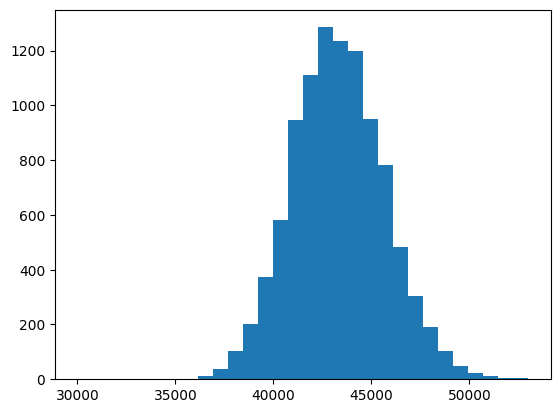

In [12]:
#[9]予測値分布の可視化
plt.hist(nikkei_F3,bins=30,range=(30000,53000))
plt.plot()

In [13]:
#[10]予測値の記述統計
print('平均値 {:.3f}'.format(np.mean(nikkei_F3)))
print('中央値 {:.3f}'.format(np.median(nikkei_F3)))
print('標準偏差 {:.3f}'.format(np.std(nikkei_F3)))
print('最大値 {:.3f}'.format(np.max(nikkei_F3)))
print('最小値 {:.3f}'.format(np.min(nikkei_F3)))

平均値 43322.927
中央値 43248.956
標準偏差 2362.925
最大値 53065.281
最小値 34700.939
